# Evaluating the VAE on groundtruth

Here, we show how to evaluate the location estimates with ground truth. We can looks at the estimated positions and compare them to the ground truth soma positions. We can also try different sorting methods and compare those methods to the ground truth.

In [11]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import h5py
import numpy as np
np.set_printoptions(suppress=True)
import math
import matplotlib.pyplot as plt
import MEArec as mr
from collections import defaultdict
from utility_functions import clustering_plotting_functions
import spikeextractors as se
import spiketoolkit as st
import spikecomparison as sc

from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.mixture import GaussianMixture

from collections import namedtuple

TrainSpike = namedtuple('DataPoint', ['amps', 'waveforms', 'ch_locs', 'center_loc', 'spike_id', 'exp_id',\
                                      'min_waveform', 'min_amp'])
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


19:51:49 [I] klustakwik KlustaKwik2 version 0.2.6


# Parameters

We now load the augmented training data and also the ground truth labels.

In [45]:
recording_directory = '/disk/scratch/cole/recordings/'
augmented_data_path = '/disk/scratch/cole/recordings/'
recording_name = 'recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5'
width = 40
amp_jitter = 10

recgen = mr.load_recordings(recording_directory + recording_name)
channel_positions = recgen.channel_positions
soma_positions = np.asarray([st.annotations['soma_position'] for st in recgen.spiketrains])
SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)

hf_AO = h5py.File(str(augmented_data_path) + 'model_data_'+ str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
amp_array = np.asarray(hf_AO['amps_list'])
channel_loc_array = np.asarray(hf_AO['channel_loc_list'])
waveforms_array = np.asarray(hf_AO['waveforms_list'])
center_loc_array = np.asarray(hf_AO['center_loc_list'])
min_channel_list = np.asarray(hf_AO['min_channel_list'])
spike_time_list = np.asarray(hf_AO['spike_time_list'])
spike_id_list = np.asarray(hf_AO['spike_id_list'])
hf_AO.close()

hf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
neuron_loc_array = np.asarray(hf_label_AO['neuron_loc_list'])
neuron_array = np.asarray(hf_label_AO['neuron_list'])
overlap_array = np.asarray(hf_label_AO['overlap_list'])
hf_label_AO.close()

Here, we can load the location estimates we saved in the previous notebook.

In [46]:
waveform_len = 60
results_path = "results/" + "loc_predictions_"+str(width) + "_" + str(amp_jitter) + "_amp_jit_wave_"+str(waveform_len)+".txt"
all_vae_errors = defaultdict(list)
vae_locs_2D = defaultdict(list)
vae_locs_3D = defaultdict(list)
all_neuron_waveforms = defaultdict(list)
all_spike_times = defaultdict(list)
index = 0
with open(results_path,"r") as f:
    for result_string in f:
        result_tokens = [float(i) for i in result_string.split(',')]
        est_loc = [float(token) for token in result_tokens[0:3]]
        max_waveform = [float(token) for token in result_tokens[3:3+waveform_len]]
        spike_time = int(result_tokens[3+waveform_len])
        neuron_id = int(result_tokens[3+waveform_len+1])
        neuron_loc = soma_positions[neuron_id]
        vae_locs_2D[neuron_id].append([est_loc[1], est_loc[2]])
        vae_locs_3D[neuron_id].append([est_loc[0], est_loc[1], est_loc[2]])
        
        error_dist = np.linalg.norm(est_loc[1:3] - neuron_loc[1:3])
        all_neuron_waveforms[neuron_id].append(max_waveform)
        all_spike_times[neuron_id].append(spike_time)
        index += 1
        all_vae_errors[neuron_id].append(error_dist)
print(results_path)

results/loc_predictions_40_10_amp_jit_wave_60.txt


Now we compare the location estimates to the true soma locations to quantify the location estimates' 2D euclidean distances from the corresponding soma positions.

In [47]:
spike_number = 0
neuron_error = 0
neuron_std = 0 
neuron_errors_all = []
neuron_stds_all = []
spike_errors_all = []
good_indices = [ 0,  7,  8, 10, 11, 12, 13, 14, 16, 19, 21, 22, 23, 25, 26, 27, 31, 33, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49]
bad_indices = list(set(list(range(50))) - set(good_indices))

for neuron in range(50):#good_indices:#range(50):
    if(len(all_vae_errors[neuron]) != 0):
        neuron_error = np.mean(all_vae_errors[neuron])
        neuron_std = np.std(all_vae_errors[neuron])
        spike_number += len(all_vae_errors[neuron])
        spike_errors_all = spike_errors_all + all_vae_errors[neuron]
        neuron_errors_all.append(neuron_error)
        neuron_stds_all.append(neuron_std)
print("Total Spike 2D Error: " + str(np.mean(spike_errors_all)) + " +- " + str(np.std(spike_errors_all)))
print("Total Neuron 2D Error: " + str(np.mean(neuron_errors_all)) + " +- " + str(np.mean(neuron_stds_all)))

Total Spike 2D Error: 8.911179085874002 +- 7.8872270377113445
Total Neuron 2D Error: 9.692479513352703 +- 5.690572279718492


Again, we can plot the location estimates as shown below.

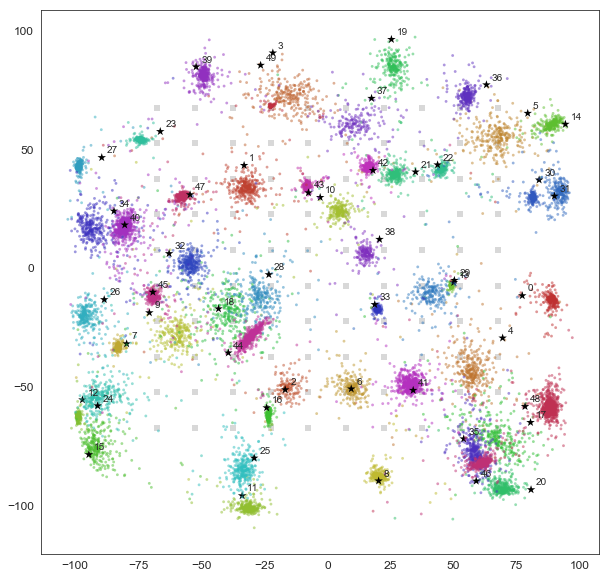

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
clustering_plotting_functions.plot2DLocations(channel_positions, range(50), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax, annotate=True);

Now we try spike sorting the data with a mixture of gaussians and then comparing to ground truth.

If pc_components = 0, then we just sort based on the location estimates.

If pc_components > 0,  then we concatenate that may pc components to the location estimates, scale the pc components with alpha, and then sort as before. This incorporates some waveform inofrmation into the clustering and increases sorting accuracy and recall.

Below, we use two principal components from 40 frame long waveforms. We then scale these principal components by an alpha of 8 and sort with a spherical-covariance GMM with 50 mixtures.

In [36]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
alpha = 8
num_clusters = 55
covariance_type = 'spherical'
middle_frame = len(all_neuron_waveforms[0][0])//2

waveforms_list = []
for neuron in range(num_neurons):
    for waveform in all_neuron_waveforms[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)

if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(num_neurons):
        for i, _ in enumerate(all_neuron_waveforms[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(all_neuron_waveforms[neuron])

cluster_data = []
labels = []
if(pc_components !=0):
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(vae_locs_3D[neuron]):
            cluster_data.append(np.concatenate((vae_loc[1:3], alpha*all_neuron_pcs[neuron][i])))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)
else:
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(vae_locs_3D[neuron]):
            cluster_data.append((vae_loc[1:3]))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)

clustering = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data)
labels =  clustering.predict(cluster_data)

#Make numpy extractor for method
SX=se.NumpySortingExtractor()
times = []
for neuron in range(num_neurons):
    for time in all_spike_times[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels):
    times_k=times[np.where(labels==k)[0]]
    times_k.sort()
    SX.add_unit(unit_id=k,times=times_k)

cmp = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX, n_jobs=1, match_score=0);
performance_measures = cmp.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures)

Alpha: 8, PCs: 2, Num Clusters: 55
accuracy                0.857843
recall                  0.877555
precision               0.974123
false_discovery_rate    0.025877
miss_rate               0.122445
dtype: float64


We can now plot the results of the GMM with the corresponding ellipses

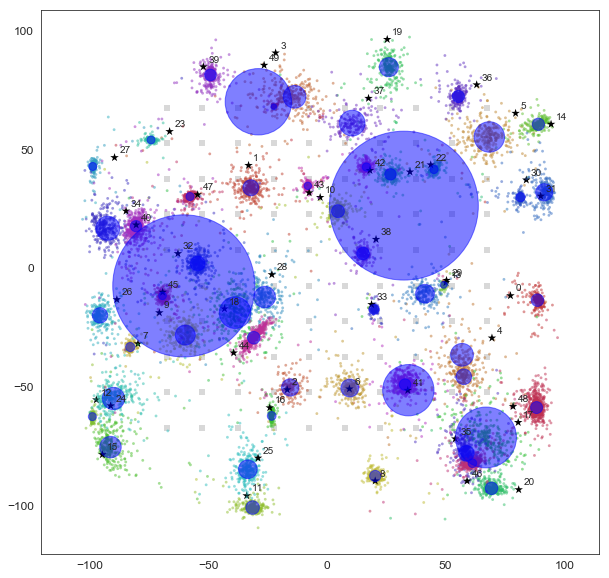

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
for i, covar in enumerate(clustering.covariances_):
    mean = clustering.means_[i]
    if covariance_type == 'full':
        covariances = covar[:2, :2]
    elif covariance_type == 'diag':
        covariances = np.diag(covar[:2])
    elif covariance_type == 'spherical':
        covariances =  np.eye(mean.shape[0]) * covar
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180 + angle, color='blue')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')
clustering_plotting_functions.plot2DLocations(channel_positions, range(num_neurons), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax);

We can now plot the full 3D location estimates from the method. As shown below, the depth estimates are not great, as the probe geometry is flat, giving little information about depth.

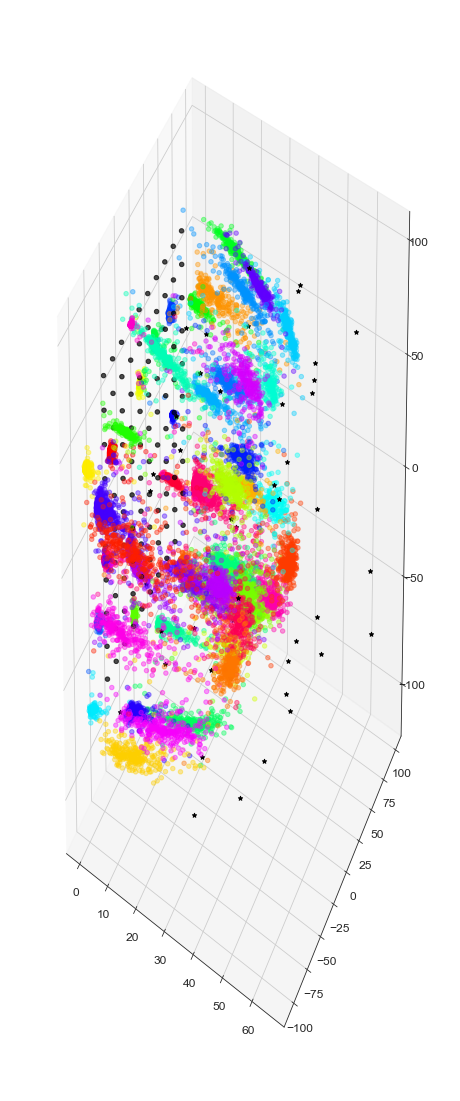

In [16]:
ax = clustering_plotting_functions.plot3DLocations(channel_positions, range(num_neurons), vae_locs_3D, soma_positions, loc_color='blue', alpha=.4);

The estimated depths and true depths are correlated though as you can see in the plot below.

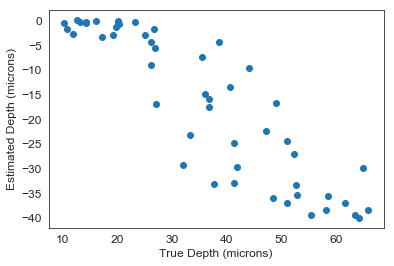

In [17]:
est_depths = []
real_depths = []
for neuron in range(50):
    real_depths.append(soma_positions[neuron][0])
    est_depths.append(np.mean(np.asarray(vae_locs_3D[neuron])[:,0]))
plt.scatter(real_depths, est_depths)
plt.ylabel("Estimated Depth (microns)")
plt.xlabel("True Depth (microns)");